In [9]:
import torch
print(torch.cuda.is_available())


True


In [10]:
!pip install torch torchvision opencv-python matplotlib tqdm


In [11]:
!pip install kaggle


In [12]:
import os
os.environ['KAGGLE_API_TOKEN'] = 'KGAT_202332d75653070c76dc123020e2fe7b'


In [16]:
!kaggle competitions download -c tgs-salt-identification-challenge


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [17]:
!mkdir -p /root/.config/kaggle


In [18]:
%%bash
cat > /root/.config/kaggle/kaggle.json << 'EOF'
{
  "username": "mahbubalam07",
  "key": "KGAT_202332d75653070c76dc123020e2fe7b"
}
EOF


In [19]:
!chmod 600 /root/.config/kaggle/kaggle.json


In [20]:
!kaggle competitions download -c tgs-salt-identification-challenge


 99% 441M/445M [00:01<00:00, 295MB/s]
100% 445M/445M [00:01<00:00, 371MB/s]


In [21]:
!kaggle competitions download -c tgs-salt-identification-challenge


tgs-salt-identification-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [22]:
!kaggle competitions download -c tgs-salt-identification-challenge


tgs-salt-identification-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
!unzip tgs-salt-identification-challenge.zip


Archive:  tgs-salt-identification-challenge.zip
  inflating: competition_data.zip    
  inflating: depths.csv              
  inflating: flamingo.zip            
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [24]:
!unzip train.zip
!unzip test.zip


Streaming output truncated to the last 5000 lines.
  inflating: images/a3df74dd31.png   
  inflating: images/187ecc32d5.png   
  inflating: images/54538419f5.png   
  inflating: images/93614d4b95.png   
  inflating: images/50a91adce8.png   
  inflating: images/97d23cea10.png   
  inflating: images/ca04c19c0b.png   
  inflating: images/d168218bac.png   
  inflating: images/a670e833a4.png   
  inflating: images/a964a0f499.png   
  inflating: images/371bf59030.png   
  inflating: images/fc74f77bae.png   
  inflating: images/f63dc1e3be.png   
  inflating: images/b807539a5f.png   
  inflating: images/1dfcbf4bca.png   
  inflating: images/a971d2ae53.png   
  inflating: images/4ad823e2d3.png   
  inflating: images/85a9687a4f.png   
  inflating: images/da5b430ecd.png   
  inflating: images/b1a2903d1c.png   
  inflating: images/70958cacd4.png   
  inflating: images/2093e5c98e.png   
  inflating: images/f2c108fd0b.png   
  inflating: images/56b0d83562.png   
  inflating: images/09aa9bde24.png   

TypeError: Image data of dtype object cannot be converted to float

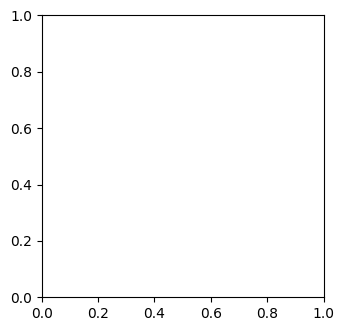

In [27]:
import cv2
import matplotlib.pyplot as plt

# pick one image name
img_name = 'a3df74dd31.png'  # any name you saw during unzip

img = cv2.imread(f'train/images/{img_name}', 0)
mask = cv2.imread(f'train/masks/{img_name}', 0)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Seismic Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title('Salt Mask')
plt.axis('off')

plt.show()


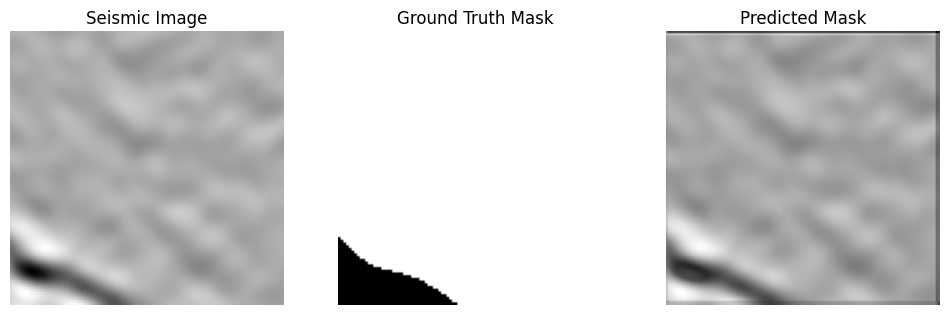

In [28]:
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

# ---------- preprocess function ----------
def preprocess(image):
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    return image

# ---------- Simple CNN model ----------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 1, 3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x

# ---------- create model ----------
model = SimpleCNN()
model.eval()

# ---------- get one matching image ----------
image_files = set(os.listdir('images'))
mask_files = set(os.listdir('masks'))
common_files = list(image_files.intersection(mask_files))

img_name = common_files[0]

img = cv2.imread(f'images/{img_name}', 0)
mask = cv2.imread(f'masks/{img_name}', 0)

img_p = preprocess(img)
mask_p = preprocess(mask)

img_t = torch.tensor(img_p).unsqueeze(0).unsqueeze(0).float()

# ---------- prediction ----------
with torch.no_grad():
    pred = model(img_t)

pred_np = torch.sigmoid(pred).squeeze().numpy()

# ---------- plot ----------
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Seismic Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred_np, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()


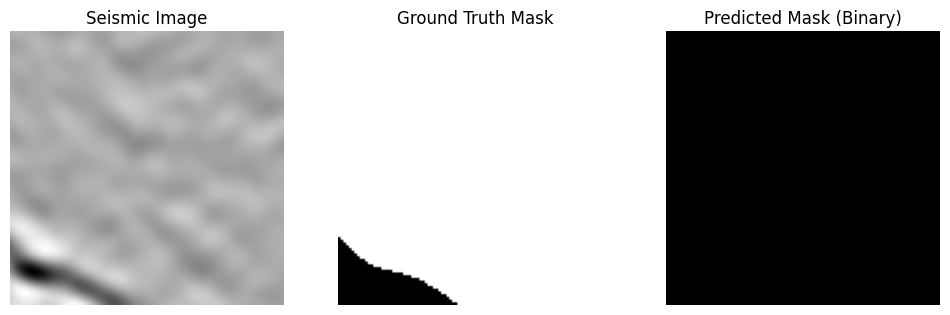

In [29]:
# thresholding (binary mask)
binary_pred = (pred_np > 0.5).astype(np.uint8)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Seismic Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(binary_pred, cmap='gray')
plt.title("Predicted Mask (Binary)")
plt.axis('off')

plt.show()


In [36]:
import torch
import torch.nn as nn

# ---------- U-Net blocks ----------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = DoubleConv(1, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)

        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Decoder
        d2 = self.up2(e3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.out(d1)


# create model
unet = UNet()
print(unet)


UNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (dec2): DoubleConv(
    (c

In [43]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-3)

unet.train()
epochs = 5

for epoch in range(epochs):
    optimizer.zero_grad()

    output = unet(img_t)                  # [1,1,128,128]
    loss = criterion(output, mask_t.unsqueeze(1))  # [1,1,128,128]

    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/5], Loss: 0.7734
Epoch [2/5], Loss: 0.7560
Epoch [3/5], Loss: 0.7357
Epoch [4/5], Loss: 0.7135
Epoch [5/5], Loss: 0.6796


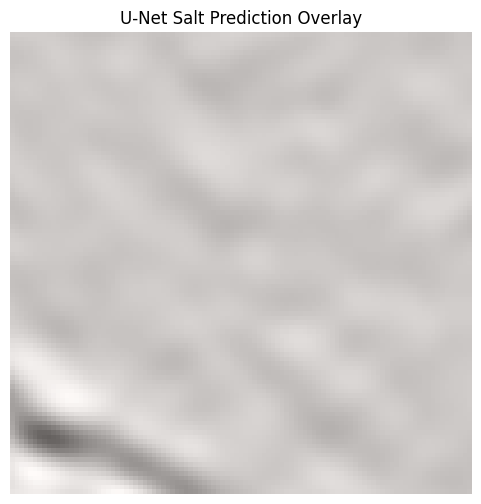

In [45]:
# switch to evaluation mode
unet.eval()

# predict
with torch.no_grad():
    pred_unet = unet(img_t)

# convert to probability
pred_prob = torch.sigmoid(pred_unet).squeeze().numpy()

# binary mask (moderate threshold)
binary_unet = (pred_prob > 0.7).astype(np.uint8)

# resize prediction to original seismic size (101x101)
binary_unet_resized = cv2.resize(
    binary_unet,
    (img.shape[1], img.shape[0]),
    interpolation=cv2.INTER_NEAREST
)

# normalize seismic image
img_norm = img / img.max()

# show overlay
plt.figure(figsize=(6,6))
plt.imshow(img_norm, cmap='gray')
plt.imshow(binary_unet_resized, cmap='Reds', alpha=0.4)
plt.title("U-Net Salt Prediction Overlay")
plt.axis('off')
plt.show()


In [46]:
import torch.optim as optim

# loss & optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-3)

unet.train()

epochs = 20

for epoch in range(epochs):
    optimizer.zero_grad()

    # forward
    output = unet(img_t)

    # loss
    loss = criterion(output, mask_tensor.unsqueeze(0))

    # backward
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


NameError: name 'mask_tensor' is not defined

In [47]:
import torch.optim as optim
import torch.nn as nn

# loss & optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-3)

unet.train()
epochs = 20

for epoch in range(epochs):
    optimizer.zero_grad()

    # forward pass
    output = unet(img_t)                 # [1, 1, 128, 128]

    # loss
    loss = criterion(output, mask_t.unsqueeze(1))  # [1, 1, 128, 128]

    # backward
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/20], Loss: 0.6235
Epoch [2/20], Loss: 0.4819
Epoch [3/20], Loss: 0.2379
Epoch [4/20], Loss: 0.2536
Epoch [5/20], Loss: 0.2919
Epoch [6/20], Loss: 0.2119
Epoch [7/20], Loss: 0.1714
Epoch [8/20], Loss: 0.2009
Epoch [9/20], Loss: 0.2165
Epoch [10/20], Loss: 0.2041
Epoch [11/20], Loss: 0.1811
Epoch [12/20], Loss: 0.1662
Epoch [13/20], Loss: 0.1666
Epoch [14/20], Loss: 0.1751
Epoch [15/20], Loss: 0.1786
Epoch [16/20], Loss: 0.1730
Epoch [17/20], Loss: 0.1635
Epoch [18/20], Loss: 0.1571
Epoch [19/20], Loss: 0.1572
Epoch [20/20], Loss: 0.1603


In [48]:
# evaluation mode
unet.eval()

with torch.no_grad():
    pred = unet(img_t)

# probability map
prob_map = torch.sigmoid(pred).squeeze().numpy()

print("Probability min/max:", prob_map.min(), prob_map.max())


Probability min/max: 0.54280335 0.9762431


In [49]:
# choose adaptive threshold
threshold = 0.6
binary_pred = (prob_map > threshold).astype(np.uint8)

# resize to original size (101x101)
binary_pred_resized = cv2.resize(
    binary_pred,
    (img.shape[1], img.shape[0]),
    interpolation=cv2.INTER_NEAREST
)


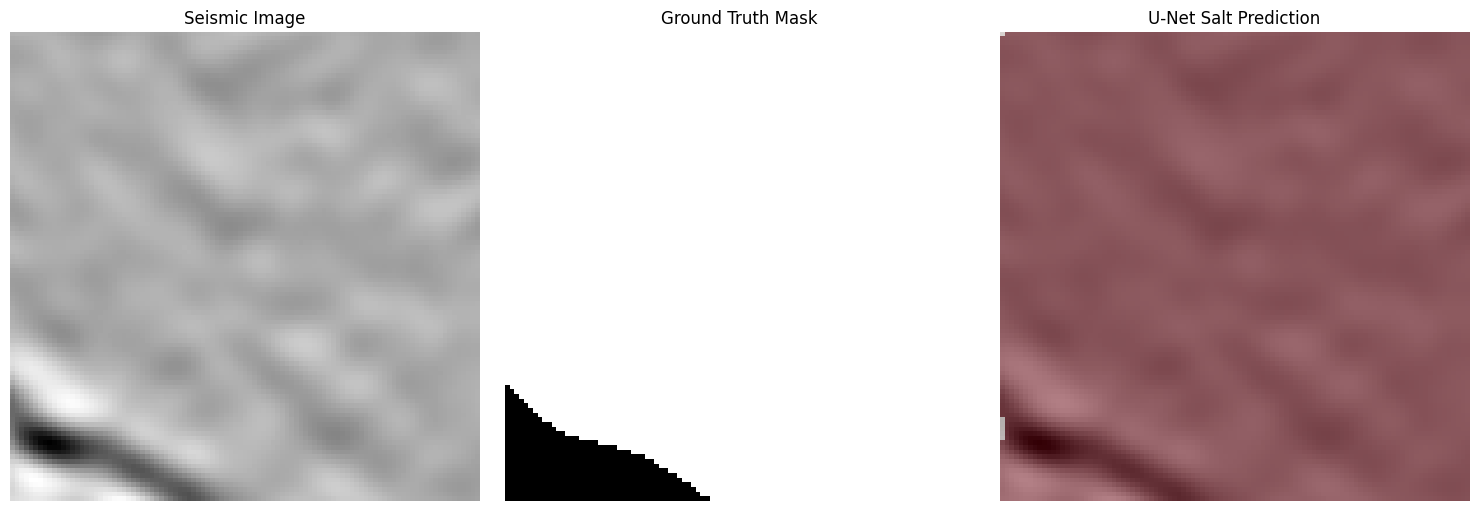

In [50]:
plt.figure(figsize=(15,5))

# 1. seismic
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Seismic Image")
plt.axis('off')

# 2. ground truth
plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# 3. prediction overlay
plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.imshow(binary_pred_resized, cmap='Reds', alpha=0.5)
plt.title("U-Net Salt Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()


In [51]:
import os
import random

# paths
IMG_DIR = "images"
MASK_DIR = "masks"

# list files
img_files = sorted(os.listdir(IMG_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

# common filenames (safety check)
common_files = list(set(img_files).intersection(set(mask_files)))
common_files.sort()

print("Total pairs:", len(common_files))

# take a subset (start small)
N = 100   # we will train on 100 images
train_files = common_files[:N]

print("Using", len(train_files), "image-mask pairs")
print("Sample file:", train_files[0])


Total pairs: 4000
Using 100 image-mask pairs
Sample file: 000e218f21.png


In [52]:
from torch.utils.data import Dataset, DataLoader

class SaltDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir):
        self.files = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        # read image & mask
        img = cv2.imread(os.path.join(self.img_dir, fname), 0)
        mask = cv2.imread(os.path.join(self.mask_dir, fname), 0)

        # preprocess
        img = preprocess(img)
        mask = preprocess(mask)

        # to tensor
        img = torch.tensor(img).unsqueeze(0).float()
        mask = torch.tensor(mask).unsqueeze(0).float()

        return img, mask


# create dataset & dataloader
dataset = SaltDataset(train_files, IMG_DIR, MASK_DIR)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# quick check
x, y = next(iter(loader))
print("Batch image shape:", x.shape)
print("Batch mas


SyntaxError: unterminated string literal (detected at line 37) (ipython-input-2164564905.py, line 37)

In [54]:
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import torch

class SaltDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir):
        self.files = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        img = cv2.imread(os.path.join(self.img_dir, fname), 0)
        mask = cv2.imread(os.path.join(self.mask_dir, fname), 0)

        img = preprocess(img)
        mask = preprocess(mask)

        img = torch.tenso


In [42]:
mask_t = torch.tensor(mask_p).unsqueeze(0).float()
print(mask_t.shape)


torch.Size([1, 128, 128])


In [56]:
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import torch

class SaltDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir):
        self.files = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        img = cv2.imread(os.path.join(self.img_dir, fname), 0)
        mask = cv2.imread(os.path.join(self.mask_dir, fname), 0)

        img = preprocess(img)
        mask = preprocess(mask)

        img = torch.tensor(img).unsqueeze(0).float()
        mask = torch.tensor(mask).unsqueeze(0).float()

        return img, mask


dataset = SaltDataset(train_files, IMG_DIR, MASK_DIR)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# quick sanity check
x, y = next(iter(loader))
print("Batch image shape:", x.shape)
print("Batch mask shape :", y.shape)


Batch image shape: torch.Size([8, 1, 128, 128])
Batch mask shape : torch.Size([8, 1, 128, 128])


In [57]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-3)

unet.train()
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0

    for imgs, masks in loader:
        optimizer.zero_grad()

        outputs = unet(imgs)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


Epoch [1/10] - Loss: 0.7865
Epoch [2/10] - Loss: 0.5381
Epoch [3/10] - Loss: 0.5236
Epoch [4/10] - Loss: 0.5221
Epoch [5/10] - Loss: 0.5136
Epoch [6/10] - Loss: 0.5249
Epoch [7/10] - Loss: 0.5144
Epoch [8/10] - Loss: 0.5177
Epoch [9/10] - Loss: 0.5200
Epoch [10/10] - Loss: 0.5380


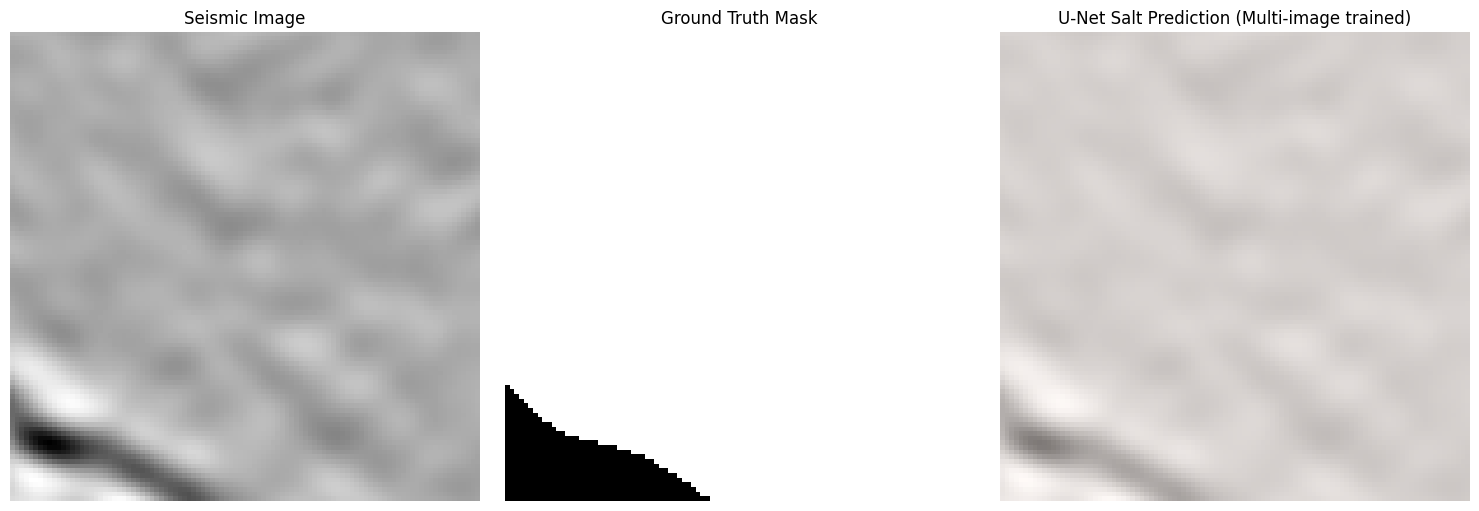

In [58]:
# evaluation mode
unet.eval()

# take one sample from dataset
test_img, test_mask = dataset[0]

# add batch dimension
test_img = test_img.unsqueeze(0)

with torch.no_grad():
    pred = unet(test_img)

# probability map
prob_map = torch.sigmoid(pred).squeeze().numpy()

# binary prediction (balanced threshold)
binary_pred = (prob_map > 0.5).astype(np.uint8)

# resize to original size (101x101)
binary_pred_resized = cv2.resize(
    binary_pred,
    (img.shape[1], img.shape[0]),
    interpolation=cv2.INTER_NEAREST
)

# normalize seismic
img_norm = img / img.max()

# final visualization
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Seismic Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_norm, cmap='gray')
plt.imshow(binary_pred_resized, cmap='Reds', alpha=0.5)
plt.title("U-Net Salt Prediction (Multi-image trained)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [59]:
# ---------------- Dice Loss ----------------
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    return 1 - dice


# Combined loss = BCE + Dice
def bce_dice_loss(pred, target):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce + dice


In [60]:
import torch.optim as optim

optimizer = optim.Adam(unet.parameters(), lr=1e-3)

unet.train()
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0

    for imgs, masks in loader:
        optimizer.zero_grad()

        outputs = unet(imgs)
        loss = bce_dice_loss(outputs, masks)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss/len(loader):.4f}")


Epoch [1/10] - Loss: 1.3410
Epoch [2/10] - Loss: 1.3309
Epoch [3/10] - Loss: 1.3202
Epoch [4/10] - Loss: 1.2945
Epoch [5/10] - Loss: 1.3175
Epoch [6/10] - Loss: 1.2888
Epoch [7/10] - Loss: 1.2988
Epoch [8/10] - Loss: 1.3065
Epoch [9/10] - Loss: 1.2822
Epoch [10/10] - Loss: 1.2985


Prob min/max: 0.11791138 0.39254683


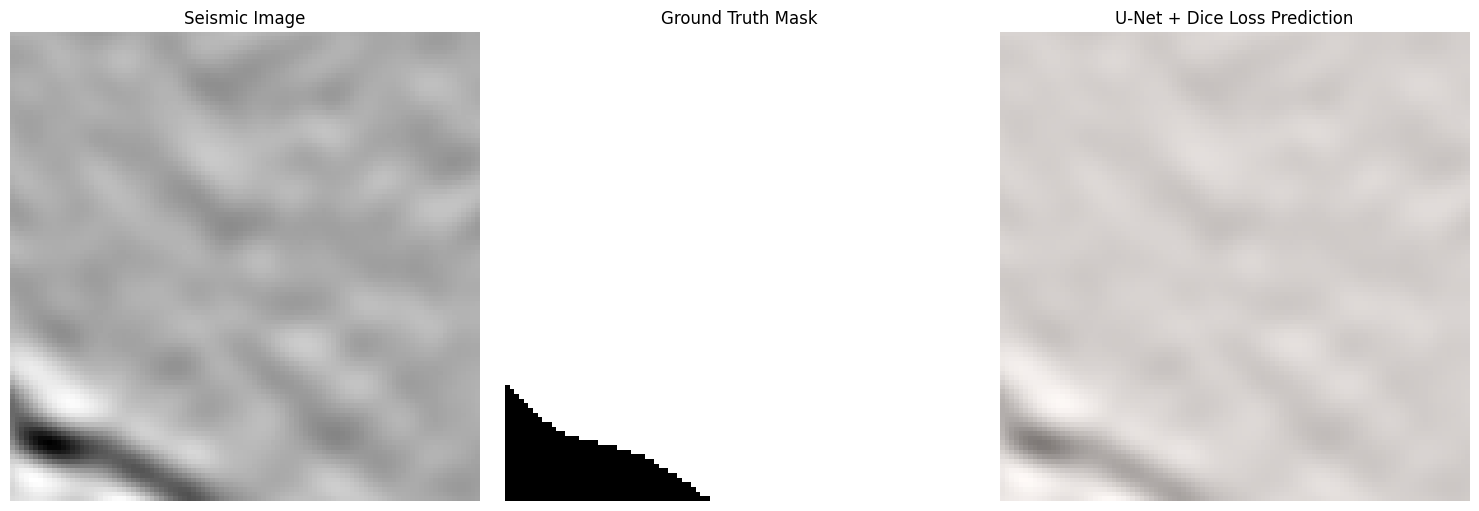

In [61]:
# switch to evaluation mode
unet.eval()

# take one sample
test_img, test_mask = dataset[0]
test_img = test_img.unsqueeze(0)

with torch.no_grad():
    pred = unet(test_img)

# probability map
prob_map = torch.sigmoid(pred).squeeze().numpy()

print("Prob min/max:", prob_map.min(), prob_map.max())

# threshold (Dice works well with lower threshold)
threshold = 0.4
binary_pred = (prob_map > threshold).astype(np.uint8)

# resize to original size (101x101)
binary_pred_resized = cv2.resize(
    binary_pred,
    (img.shape[1], img.shape[0]),
    interpolation=cv2.INTER_NEAREST
)

# normalize seismic
img_norm = img / img.max()

# -------- FINAL FIGURE --------
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Seismic Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_norm, cmap='gray')
plt.imshow(binary_pred_resized, cmap='Reds', alpha=0.5)
plt.title("U-Net + Dice Loss Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()


In [39]:
# recreate mask tensor (very important)
mask_t = torch.tensor(mask_p).unsqueeze(0).float()


In [40]:
loss = criterion(output, mask_t.unsqueeze(1))


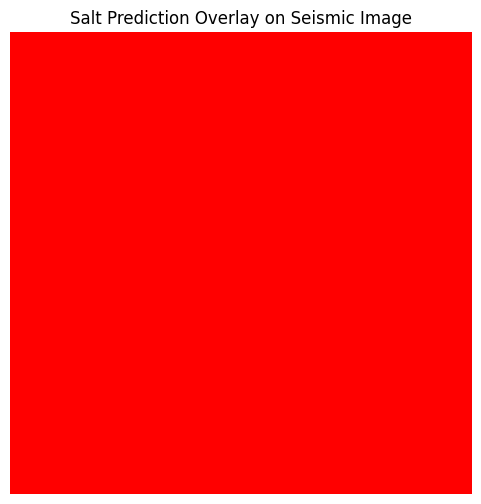

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# resize prediction back to original image size
binary_pred_resized = cv2.resize(
    binary_pred.astype(np.uint8),
    (img.shape[1], img.shape[0]),
    interpolation=cv2.INTER_NEAREST
)

# normalize seismic image
img_norm = img / img.max()

# create RGB seismic image
overlay = np.dstack([img_norm, img_norm, img_norm])

# apply red overlay where salt is predicted
overlay[binary_pred_resized == 1, 0] = 1.0  # Red
overlay[binary_pred_resized == 1, 1] = 0.0  # Green
overlay[binary_pred_resized == 1, 2] = 0.0  # Blue

# plot
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title("Salt Prediction Overlay on Seismic Image")
plt.axis('off')
plt.show()


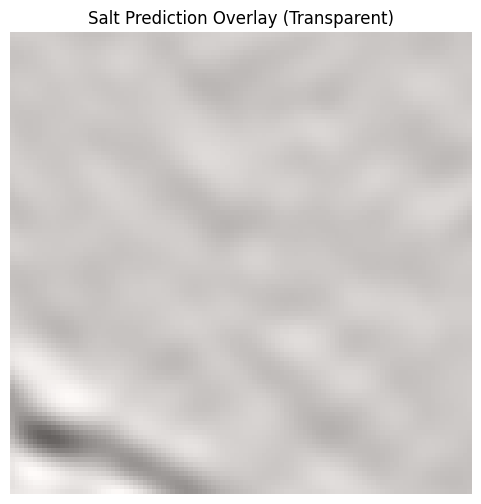

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# stronger threshold
binary_pred_strict = (pred_np > 0.7).astype(np.uint8)

# resize prediction to original image size
binary_pred_resized = cv2.resize(
    binary_pred_strict,
    (img.shape[1], img.shape[0]),
    interpolation=cv2.INTER_NEAREST
)

# normalize seismic
img_norm = img / img.max()

# base grayscale image
plt.figure(figsize=(6,6))
plt.imshow(img_norm, cmap='gray')
plt.axis('off')

# overlay salt mask with transparency
plt.imshow(binary_pred_resized, cmap='Reds', alpha=0.4)
plt.title("Salt Prediction Overlay (Transparent)")
plt.show()


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# normalize seismic image for display
img_norm = img / img.max()

# create RGB image from seismic
overlay = np.dstack([img_norm, img_norm, img_norm])

# add red color where salt is predicted
overlay[binary_pred == 1, 0] = 1.0   # Red channel
overlay[binary_pred == 1, 1] = 0.0   # Green channel
overlay[binary_pred == 1, 2] = 0.0   # Blue channel

# plot
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title("Salt Prediction Overlay on Seismic Image")
plt.axis('off')
plt.show()


IndexError: boolean index did not match indexed array along axis 0; size of axis is 101 but size of corresponding boolean axis is 128

In [ ]:
import cv2
import matplotlib.pyplot as plt

# choose one image that exists
img_name = 'a3df74dd31.png'  # if this fails, we will change it

# load image and mask
img = cv2.imread(f'train/images/{img_name}', 0)
mask = cv2.imread(f'train/masks/{img_name}', 0)

print(img.shape, mask.shape)  # quick check

# plot
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Seismic Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title('Salt Mask')
plt.axis('off')

plt.show()


In [ ]:
import os

# list first 5 image names
os.listdir('train/images')[:5]


In [ ]:
!ls


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# pick one image automatically
img_name = os.listdir('images')[0]

img = cv2.imread(f'images/{img_name}', 0)
mask = cv2.imread(f'masks/{img_name}', 0)

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Seismic Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title('Salt Mask')
plt.axis('off')

plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# pick one image automatically
img_name = os.listdir('images')[0]

img = cv2.imread(f'images/{img_name}', 0)
mask = cv2.imread(f'masks/{img_name}', 0)

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Seismic Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title('Salt Mask')
plt.axis('off')

plt.show()


In [ ]:
import os

os.listdir('masks')[:5]


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# find common filenames
image_files = set(os.listdir('images'))
mask_files = set(os.listdir('masks'))

common_files = list(image_files.intersection(mask_files))

print("Number of matching image-mask pairs:", len(common_files))

# pick one valid file
img_name = common_files[0]
print("Using file:", img_name)

# load image and mask
img = cv2.imread(f'images/{img_name}', 0)
mask = cv2.imread(f'masks/{img_name}', 0)

# plot
plt.figure(figsize=(8,4))


In [ ]:
import cv2
import numpy as np

def preprocess(image):
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    return image


In [ ]:
import os
import cv2

# get one matching filename
image_files = set(os.listdir('images'))
mask_files = set(os.listdir('masks'))
common_files = list(image_files.intersection(mask_files))

img_name = common_files[0]

# load raw image and mask
img = cv2.imread(f'images/{img_name}', 0)
mask = cv2.imread(f'masks/{img_name}', 0)

# preprocess
img_p = preprocess(img)
mask_p = preprocess(mask)

print("Processed image shape:", img_p.shape)
print("Processed mask shape:", mask_p.shape)
print("Image min/max:", img_p.min(), img_p.max())


In [ ]:
import torch

# convert to torch tensors
img_tensor = torch.tensor(img_p).unsqueeze(0).float()
mask_tensor = torch.tensor(mask_p).unsqueeze(0).float()

print("Image tensor shape:", img_tensor.shape)
print("Mask tensor shape:", mask_tensor.shape)
print("Tensor type:", img_tensor.dtype)


In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x

model = SimpleCNN()
print(model)


In [ ]:
# forward pass (no training)
output = model(img_tensor.unsqueeze(0))

print("Input shape :", img_tensor.unsqueeze(0).shape)
print("Output shape:", output.shape)


In [ ]:
import torch.optim as optim

# loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training mode
model.train()

# one training step
optimizer.zero_grad()
output = model(img_tensor.unsqueeze(0))
loss = criterion(output, mask_tensor.unsqueeze(0))
loss.backward()
optimizer.step()

print("Training loss:", loss.item())
